### Import packages

In [1]:
import numpy as np
from torchvision.datasets import CIFAR100
from torchvision import transforms
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle

### Load pre-trained resnet50 (ImageNet weights used here)

In [4]:
model = torch.hub.load('pytorch/vision', 'resnet50', pretrained = True)
modules = list(model.children())[:-1]
model = nn.Sequential(*modules)
for p in model.parameters():
    p.requires_grad = False
model.cuda();

### Load CIFAR100 training set and perform transformations

In [5]:
tr_normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.228, 0.224, 0.225])
transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            tr_normalize])
dataset = CIFAR100('../data/cifar100/',train=True, download=True, transform=transforms)

In [6]:
BATCH_SIZE = 8

In [7]:
loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1)

### Extract resnet50 embeddings for each CIFAR100 data item

In [8]:
all_labels = []
all_embeddings = []
torch.cuda.empty_cache()
model.eval()
for data,labels in tqdm(loader):
    new_labels = labels.numpy().tolist()
    all_labels += new_labels
    data = data.cuda()
    embeddings = model(data.cuda())
    all_embeddings.append(np.reshape(embeddings.detach().cpu().numpy(),(len(new_labels),-1)))
all_embeddings = np.vstack(all_embeddings)

### Save embeddings for posterity

In [9]:
DATA_PATH = '../data/cifar100/cifar100_embeddings.npy'
LABELS_PATH = '../data/cifar100/cifar100_labels.npy'

In [10]:
np.save(DATA_PATH, all_embeddings)
np.save(LABELS_PATH, np.array(all_labels))

In [11]:
all_embeddings = np.load(DATA_PATH)
all_labels = np.load(LABELS_PATH)

In [13]:
class_nums = np.unique(all_labels)

### Load class names from metadata file

In [ ]:
with open("../data/cifar100/cifar-100-python/meta", 'rb') as f:
  cifar_dict = pickle.load(f, encoding = "bytes")

class_names = np.array(cifar_dict[b"fine_label_names"], dtype = "str")

### Reduce dimensionality of extracted embeddings using UMAP

In [26]:
from umap import UMAP
import umap.plot
from sklearn.preprocessing import LabelEncoder

X_dr = UMAP(n_components = 2).fit(all_embeddings).embedding_

2025-01-15 04:32:10.220722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-15 04:32:10.220780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-15 04:32:10.221997: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 04:32:10.228087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.11/site-packages/numba/np/ufun

### Plot 2D UMAP embeddings and visualize shape of fitted Gaussian for each class

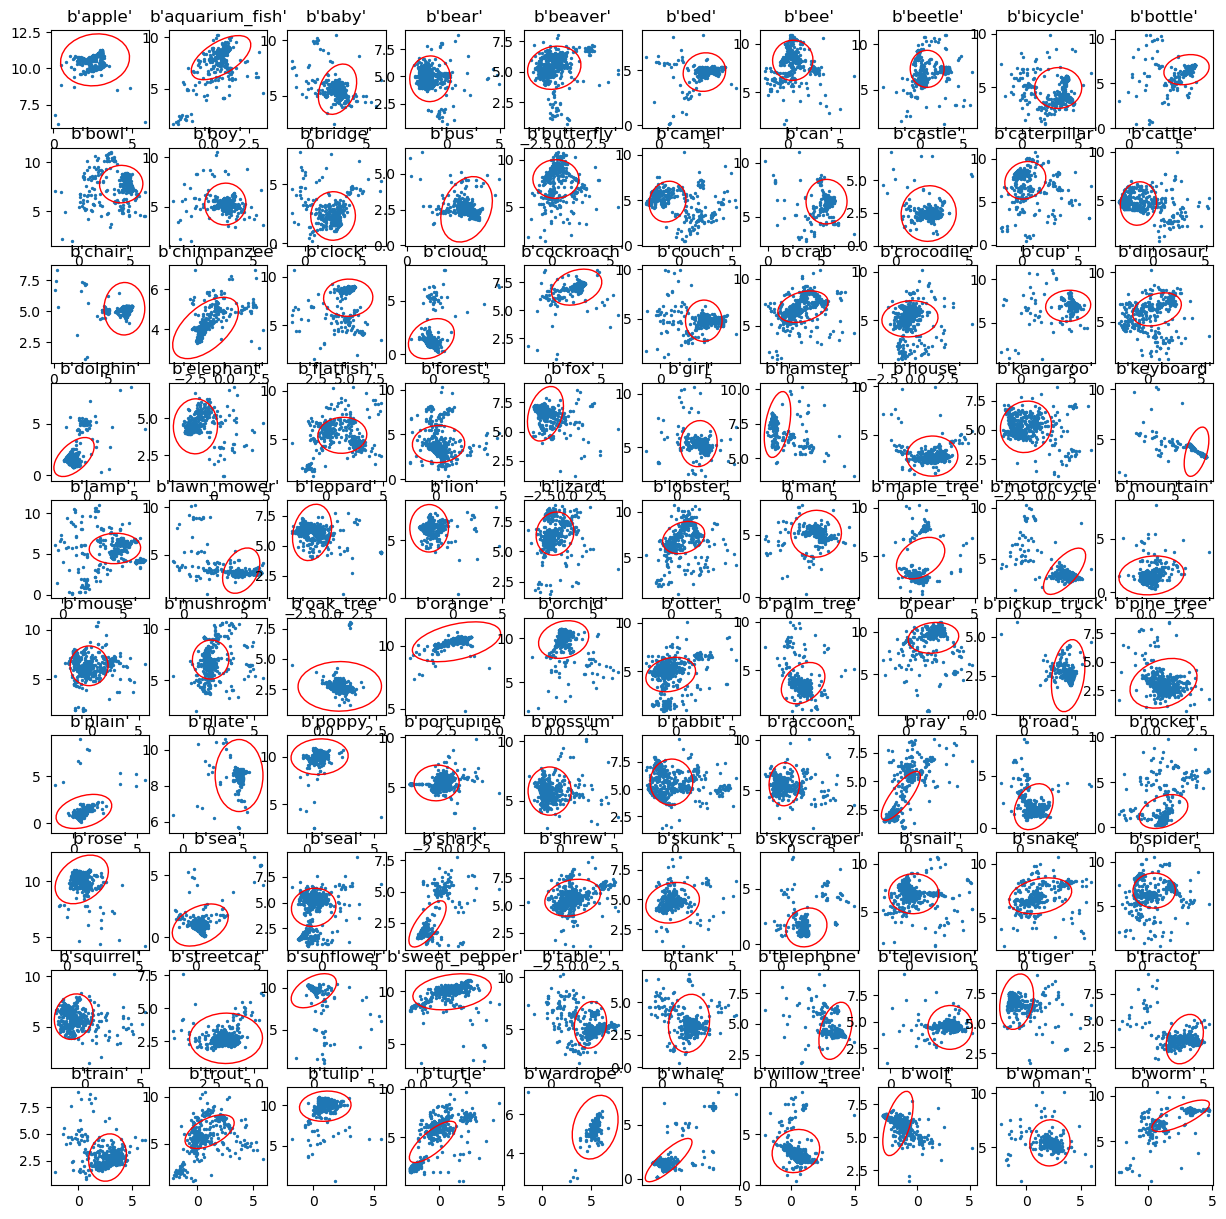

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_ellipse(mean, cov, ax, n_std=2, **kwargs):
    """
    Plots an ellipse representing the covariance matrix.

    Args:
        mean: The mean of the data (x, y).
        cov: The covariance matrix.
        ax: The matplotlib axes object to plot on.
        n_std: The number of standard deviations to represent.
        **kwargs: Additional keyword arguments passed to the Ellipse patch.
    """

    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    angle = np.arctan2(cov[0, 1], cov[0, 0]) * 180 / np.pi

    ellipse = Ellipse(mean, 
                      width=ell_radius_x * 2 * n_std, 
                      height=ell_radius_y * 2 * n_std, 
                      angle=angle, 
                      **kwargs)

    ax.add_patch(ellipse)

    return ellipse

fig, ax = plt.subplots(10, 10, figsize=(15, 15))
class_splits = []
for i, name in zip(class_nums, cifar_dict[b'fine_label_names']):
    X_class = X_dr[all_labels == i]
    class_splits += [X_class]
    mean = np.mean(X_class, axis = 0)
    cov = np.cov(X_class.T)
    ax[i // 10, i % 10].scatter(X_class[:, 0], X_class[:, 1], s = 2)
    ax[i // 10, i % 10].set_title(name)
    ellipse_data = plot_ellipse(mean, cov,  ax[i // 10, i % 10], facecolor='none', edgecolor='red')
plt.show()

### Define KL Divergence function for multidimensional distributions

In [30]:
# https://mail.python.org/pipermail/scipy-user/2011-May/029521.html

import numpy as np

def KLdivergence(x, y, approx = True):
    """Compute the Kullback-Leibler divergence between two multivariate samples.
    Parameters
    ----------
    x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
    y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
    Returns
    -------
    out : float
    The estimated Kullback-Leibler divergence D(P||Q).
    References
    ----------
    Pérez-Cruz, F. Kullback-Leibler divergence estimation of
    continuous distributions IEEE International Symposium on Information
    Theory, 2008.
    """
    if not approx:
        d = x.shape[1]
        mu1 = np.expand_dims(x.mean(axis = 0), 1)
        mu2 = np.expand_dims(y.mean(axis = 0), 1)
        cov1 = np.cov(x.T)
        cov2 = np.cov(y.T)

        # https://stats.stackexchange.com/q/60699

        return 0.5 * (np.log(np.linalg.det(cov2)/np.linalg.det(cov1)) - d + np.trace(np.linalg.inv(cov2).dot(cov1)) + (mu2 - mu1).T.dot(np.linalg.inv(cov2)).dot((mu2 - mu1)))
    
        
    from scipy.spatial import cKDTree as KDTree
    
    # Check the dimensions are consistent
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    
    n,d = x.shape
    m,dy = y.shape
    
    assert(d == dy)
    
    
    # Build a KD tree representation of the samples and find the nearest neighbour
    # of each point in x.
    xtree = KDTree(x)
    ytree = KDTree(y)
    
    # Get the first two nearest neighbours for x, since the closest one is the
    # sample itself.
    r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
    s = ytree.query(x, k=1, eps=.01, p=2)[0]
    
    # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
    # on the first term of the right hand side.
    return - np.log(r/s).sum() * d / n + np.log(m / (n - 1.))
    


### Compute KL divergence between each class in CIFAR100 and store values in matrix

In [33]:
kls_cf = dict()
kls_cf_matrix = np.zeros((100, 100))
for i in range(len(class_splits)):
    for j in range(i + 1, len(class_splits)):
        temp_val = (KLdivergence(class_splits[i], class_splits[j], approx = False) + KLdivergence(class_splits[j], class_splits[i], approx = False)) / 2
        kls_cf[(class_names[i], class_names[j])] = temp_val
        kls_cf_matrix[i, j] = kls_cf_matrix[j, i] = temp_val


/tmp/ipykernel_332/3162231668.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kls_cf_matrix[i, j] = kls_cf_matrix[j, i] = temp_val


### Save KL divergence matrix

In [43]:
np.save("cifar100_kl_div_matrix.npy", kls_cf_matrix)
np.save("cifar100_class_names.npy", class_names)

### Test out the subset generation function

In [2]:
from cifar100_subset_generation import generate_subset, dist_matrix, class_names

subset = generate_subset(10, similar_classes = True)
list(map(lambda x: class_names[x], subset["classes"])), round(subset["max_dist"], 3)

(['bed',
  'bicycle',
  'lamp',
  'bottle',
  'bowl',
  'can',
  'table',
  'clock',
  'couch',
  'cup'],
 6.644)